In [1]:
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np

In [50]:
tf.__version__

'2.5.0-dev20210222'

In [2]:
def parse_data(path):
    for l in open(path,'r'):
        yield json.loads(l)
    

# Data preprocessing

In [3]:
data = list(parse_data('./Sarcasm_Headlines_Dataset_v2.json'))
heads,labels = [],[]
is_sarc,isnt_sarc = [],[]
for item in data:
    heads.append(item['headline'])
    labels.append(item['is_sarcastic'])
    if item['is_sarcastic'] == 1:
        is_sarc.append(item['headline'])
    if item['is_sarcastic'] == 0:
        isnt_sarc.append(item['headline'])


In [4]:
data[4]

{'is_sarcastic': 1,
 'headline': "mother comes pretty close to using word 'streaming' correctly",
 'article_link': 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546'}

In [5]:
def tokenize(texts): # input list of texts(strings)
    tokd = []
    for sent in texts:
        sent = nltk.word_tokenize(sent)
        for each in sent:
            tokd.append(each)
    return tokd

is_sarc_tokd = tokenize(is_sarc)
isnt_sarc_tokd = tokenize(isnt_sarc)

        

In [6]:
isnt_sarc_tokd[:12]

['dem',
 'rep.',
 'totally',
 'nails',
 'why',
 'congress',
 'is',
 'falling',
 'short',
 'on',
 'gender',
 ',']

In [7]:
stopwords = nltk.corpus.stopwords.words('english')

In [8]:
def unw_filter(pos_tagged):
    word, tag = pos_tagged
    if not word.isalpha() or word in stopwords:
        return False
    return True
is_sarc_words = [w for w,tag in filter(unw_filter,nltk.pos_tag(is_sarc_tokd))]
isnt_sarc_words = [w for w,tag in filter(unw_filter,nltk.pos_tag(isnt_sarc_tokd))]

In [9]:
is_sarc_words[:15]

['thirtysomething',
 'scientists',
 'unveil',
 'doomsday',
 'clock',
 'hair',
 'loss',
 'inclement',
 'weather',
 'prevents',
 'liar',
 'getting',
 'work',
 'mother',
 'comes']

In [10]:
isnt_sarc_words[:15]

['dem',
 'totally',
 'nails',
 'congress',
 'falling',
 'short',
 'gender',
 'racial',
 'equality',
 'eat',
 'veggies',
 'deliciously',
 'different',
 'recipes',
 'white']

# Feature Extraction

In [11]:
sarc_fd = nltk.FreqDist(is_sarc_words)
not_sarc_fd = nltk.FreqDist(isnt_sarc_words)
common_set = set(sarc_fd).intersection(not_sarc_fd)

sarc_fd.most_common(15)

[('man', 1269),
 ('new', 981),
 ('report', 515),
 ('area', 487),
 ('woman', 387),
 ('nation', 387),
 ('trump', 381),
 ('one', 295),
 ('time', 276),
 ('day', 265),
 ('still', 247),
 ('study', 241),
 ('like', 237),
 ('get', 224),
 ('back', 217)]

In [12]:
not_sarc_fd.most_common(25)

[('trump', 1401),
 ('new', 670),
 ('donald', 455),
 ('says', 349),
 ('women', 310),
 ('one', 249),
 ('people', 238),
 ('world', 235),
 ('man', 233),
 ('obama', 232),
 ('first', 228),
 ('day', 214),
 ('gop', 213),
 ('make', 213),
 ('like', 205),
 ('could', 203),
 ('clinton', 201),
 ('get', 198),
 ('black', 190),
 ('life', 185),
 ('watch', 184),
 ('house', 182),
 ('america', 180),
 ('time', 178),
 ('white', 176)]

In [13]:
#Remove common words

for each in common_set:
    del sarc_fd[each]
    del not_sarc_fd[each]

In [14]:
sarc_fd.most_common(15)

[('fucking', 100),
 ('shit', 77),
 ('clearly', 56),
 ('fuck', 51),
 ('realizes', 42),
 ('kavanaugh', 37),
 ('unable', 37),
 ('archives', 33),
 ('per', 30),
 ('coworkers', 29),
 ('asshole', 29),
 ('recommends', 29),
 ('currently', 29),
 ('relieved', 29),
 ('recommend', 26)]

In [15]:
not_sarc_fd.most_common(15)

[('huffpost', 62),
 ('kardashian', 51),
 ('jenner', 50),
 ('queer', 50),
 ('trans', 49),
 ('lgbt', 39),
 ('lgbtq', 32),
 ('roundup', 32),
 ('trevor', 30),
 ('noah', 30),
 ('funniest', 28),
 ('huffpollster', 24),
 ('corden', 24),
 ('hill', 24),
 ('hawaii', 24)]

In [16]:
top_100_sarc = {w for w,cnt in sarc_fd.most_common(100)}
top_100_not_sarc = {w for w,cnt in not_sarc_fd.most_common(100)}

### Bigrams

In [17]:
sarc_bigrams = nltk.collocations.BigramCollocationFinder.from_words(is_sarc_words)
sarc_bigrams.ngram_fd.most_common(25)

[(('area', 'man'), 263),
 (('white', 'house'), 125),
 (('study', 'finds'), 123),
 (('introduces', 'new'), 68),
 (('unveils', 'new'), 58),
 (('area', 'woman'), 49),
 (('supreme', 'court'), 45),
 (('new', 'study'), 44),
 (('high', 'school'), 43),
 (('pope', 'francis'), 42),
 (('releases', 'new'), 39),
 (('hillary', 'clinton'), 38),
 (('ca', 'believe'), 36),
 (('historical', 'archives'), 32),
 (('local', 'man'), 30),
 (('report', 'finds'), 30),
 (('paul', 'ryan'), 29),
 (('new', 'york'), 28),
 (('onion', 'social'), 26),
 (('poll', 'finds'), 25),
 (('mike', 'pence'), 24),
 (('one', 'day'), 23),
 (('ted', 'cruz'), 23),
 (('finds', 'americans'), 23),
 (('video', 'game'), 22)]

In [18]:
not_sarc_trigrams = nltk.collocations.BigramCollocationFinder.from_words(isnt_sarc_words)
not_sarc_trigrams.ngram_fd.most_common(25)

[(('donald', 'trump'), 444),
 (('hillary', 'clinton'), 141),
 (('new', 'york'), 91),
 (('white', 'house'), 86),
 (('supreme', 'court'), 75),
 (('bernie', 'sanders'), 64),
 (('health', 'care'), 59),
 (('climate', 'change'), 58),
 (('morning', 'email'), 56),
 (('need', 'know'), 52),
 (('north', 'korea'), 46),
 (('ted', 'cruz'), 42),
 (('high', 'school'), 33),
 (('stephen', 'colbert'), 33),
 (('taylor', 'swift'), 31),
 (('trump', 'administration'), 31),
 (('pope', 'francis'), 30),
 (('new', 'year'), 29),
 (('trevor', 'noah'), 29),
 (('sexual', 'assault'), 29),
 (('paul', 'ryan'), 28),
 (('fox', 'news'), 27),
 (('mental', 'health'), 27),
 (('north', 'carolina'), 27),
 (('kim', 'kardashian'), 26)]

# Pipelining

In [19]:
char_dataset = tf.data.Dataset.from_tensor_slices((heads,labels))

In [20]:
for example, label in char_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b'thirtysomething scientists unveil doomsday clock of hair loss'
label:  1


In [21]:
data_size = len(data)
train_size = int(0.7 * data_size )
test_size = int(0.3 * data_size )

train_data = char_dataset.take(train_size)
test_data = char_dataset.skip(train_size)

In [22]:
buffer_size = 1000
batch_size = 256

train_data = train_data.shuffle(buffer_size).batch(batch_size)
test_data = test_data.batch(batch_size)

In [23]:
vocab_size=10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size)
encoder.adapt(train_data.map(lambda text, label: text))

In [24]:
for example, label in train_data.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])


texts:  [b"here's how much betsy devos and her family spent to back the gop senators who confirmed her"
 b'hero soldier receives presidential thumbs-up award'
 b"the director of hbo's new james foley documentary on making a movie about his childhood pal"]

labels:  [0 1 0]


In [25]:
'''vocab = np.array(encoder.get_vocabulary())
vocab[:25]'''

'vocab = np.array(encoder.get_vocabulary())\nvocab[:25]'

# Model building

In [26]:
from tensorflow.keras.regularizers import l1,l2

In [27]:
model = tf.keras.Sequential( [
    encoder,
    tf.keras.layers.Embedding(input_dim=vocab_size+1,output_dim=64,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True,kernel_regularizer=l2(0.01))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,kernel_regularizer=l2(0.01))),

    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [30]:
history = model.fit(train_data, epochs=100,
                    validation_data=test_data, 
                    validation_steps=30,callbacks=early_stop)

Epoch 1/100
79/79 [==============================] - 30s 200ms/step - loss: 6.3793 - accuracy: 0.5047 - val_loss: 5.7716 - val_accuracy: 0.5257
Epoch 2/100
79/79 [==============================] - 12s 153ms/step - loss: 5.5876 - accuracy: 0.5216 - val_loss: 5.0619 - val_accuracy: 0.5257
Epoch 3/100
79/79 [==============================] - 11s 146ms/step - loss: 4.9031 - accuracy: 0.5387 - val_loss: 4.4465 - val_accuracy: 0.5259
Epoch 4/100
79/79 [==============================] - 12s 148ms/step - loss: 4.3091 - accuracy: 0.5658 - val_loss: 3.9100 - val_accuracy: 0.6786
Epoch 5/100
79/79 [==============================] - 12s 151ms/step - loss: 3.7909 - accuracy: 0.6222 - val_loss: 3.4293 - val_accuracy: 0.7738
Epoch 6/100
79/79 [==============================] - 12s 151ms/step - loss: 3.3154 - accuracy: 0.6853 - val_loss: 2.9302 - val_accuracy: 0.8064
Epoch 7/100
79/79 [==============================] - 12s 150ms/step - loss: 2.8528 - accuracy: 0.7604 - val_loss: 2.5069 - val_accuracy:

In [31]:
test_loss, test_acc = model.evaluate(test_data)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))


34/34 [==============================] - 2s 47ms/step - loss: 1.1283 - accuracy: 0.8402
Test Loss: 1.128290057182312
Test Accuracy: 0.8402050137519836


# Evaluation

In [32]:
import matplotlib.pyplot as plt
def plot_graphs(hist,metric):
    plt.plot(hist.history[metric])
    plt.plot(hist.history['val_'+metric])
    plt.legend([metric,'val_'+metric])

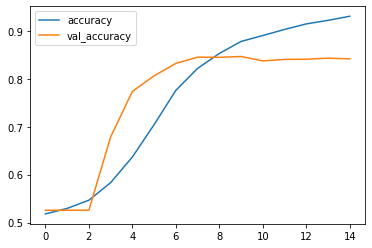

In [33]:
plot_graphs(history,'accuracy')

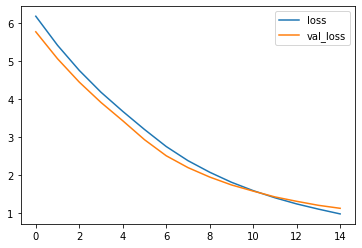

In [34]:
plot_graphs(history,'loss')

# Testing

In [35]:
n = 2651
heads[n],labels[n]

('dept. of transportation to replace highway mile markers with dead raccoons',
 1)

In [36]:
sample = heads[n]

preds = model.predict(np.array([sample]))

In [54]:
np.array(type(heads[n]))

array(<class 'str'>, dtype=object)

In [37]:
preds

array([[0.99740744]], dtype=float32)

In [38]:
others = ['Man Returns To Work After Vacation With Fresh, Reenergized Hatred For Job', #yes
          'Queen missed second church service following conversation to Satanism', #yes
          'The Day Dostoyevsky Discovered the Meaning of Life in a Dream', #no
          'Proof Finds That All Change Is a Mix of Order and Randomness', #no
         'Iran Eases Up on Inspections Threat', #no
        'France Still Struggles With the Shadow of the ‘War Without a Name', #no
         'Zuckerberg could make a very good dating app with all the information he has collected about us.', #yes
        'It’s so cold outside that I saw a politician with his hands in his own pocket!' ] #yes

In [39]:
preds1 = model.predict(np.array(others))
preds1

array([[0.9981252 ],
       [0.9920792 ],
       [0.01537335],
       [0.01536202],
       [0.31184855],
       [0.01541242],
       [0.0144951 ],
       [0.87671673]], dtype=float32)

In [40]:
preds[0][0]

0.99740744

In [41]:
model.save('./saved_model/1')

INFO:tensorflow:Assets written to: ./saved_model/1\assets


INFO:tensorflow:Assets written to: ./saved_model/1\assets


In [42]:
loaded_model = tf.keras.models.load_model('./saved_model/1',compile=False)

In [55]:
loaded_model.predict(np.array([sample]))

array([[0.99740744]], dtype=float32)

In [56]:
pred = []

In [57]:
type(pred)

list